In [1]:
# for image compression testing
import glob, os
import time
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# for getting screenshots
import numpy as np
from PIL import Image, ImageGrab

# for getting keyboard input
from pynput import keyboard, mouse
from pynput.keyboard import Key
from pynput.keyboard import Controller as keyController
from pynput.mouse import Controller

# makes the program DPI aware so that it can actually capture the screen correctly
# coordinates would be messed up otherwise
from ctypes import windll
user32 = windll.user32
user32.SetProcessDPIAware()

1

In [2]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
# for getting keyboard/mouse input to set the bound coordinates
kb = keyController()
mouse = Controller()

In [4]:
def getTrainingData():
    training = True
    keyPresses = list()

    def on_press(key):
        if key == Key.esc:
            keyboard.Listener.stop(listener2)
            print("Lister 2 stopped!")
        if key == Key.space:
            keyPresses.pop()
            keyPresses.append(1)
    
    # Collect events until released
    listener2 = keyboard.Listener(on_press = on_press, on_release = None)
    listener2.start()
    print("Listener 2 started!")
    screenShotsTaken = 0
    images = list()
    scale = 0.05
    elapsedTime = 0    
    startTime = time.time()

    while training:                        
        im = ImageGrab.grab((x1, y1, x2, y2)) # get screenshot
        im = im.convert("L") # convert to grayscale
        width, height = im.size
        im = im.resize((round(scale * width), round(scale * height)) , Image.BICUBIC) # scale down the image
        np_im = np.array(im) / 255 # scale down the pixel values

        images.append(np_im)
        keyPresses.append(0)
        screenShotsTaken = screenShotsTaken + 1   
        training = listener2.running
        
    elapsedTime = time.time() - startTime              
    print("Total time: " + str(time.time() - startTime  ))
    print("Screenshots Taken: " + str(screenShotsTaken))
    print("Average time per screenshot: " + str(elapsedTime / screenShotsTaken))
    
    frameRate = elapsedTime / screenShotsTaken * 1000
    
    result = list()
    result.append(images)
    result.append(keyPresses)
    result.append(frameRate)
    return result

In [54]:
def playGame(model):    
    playing = True
    
    def on_press(key):
        if key == Key.esc:
            keyboard.Listener.stop(listener3)
            print("Listener 3 stopped!")
        
    # Collect events until released
    listener3 = keyboard.Listener(on_press = on_press, on_release = None)
    listener3.start()
    print("Listener 3 started!")
    
    while playing:
        im = ImageGrab.grab((x1, y1, x2, y2)) # get screenshot
        im = im.convert("L") # convert to grayscale
        width, height = im.size
        
        scale = 0.05
        im = im.resize((round(scale * width), round(scale * height)), Image.BICUBIC) # scale for the network
        
        # im = im.resize((62, 31), Image.BICUBIC)
        np_im = np.array(im) / 255 # scale down the pixel values
        output = model.predict(np.expand_dims(np_im, axis = 0))
        print(output)
        if output[0][0] > 0.1:
            kb.press(Key.space)
            kb.release(Key.space)
            
        playing = listener3.running

In [5]:
def on_press(key):
    global x1, y1, x2, y2
    if key == Key.shift_l:
        if x1 == 0:
            x1, y1 = mouse.position
        else:
            x2, y2 = mouse.position
    if key == Key.print_screen:
        # display screenshot to confirm bound coordinates
        im = ImageGrab.grab((x1, y1, x2, y2))
        plt.imshow(np.asarray(im))
        plt.title("Is this screencap right?")
        plt.show()

In [6]:
def on_release(key):
    if key == Key.ctrl_l:
        # Stop listener
        keyboard.Listener.stop(listener)
        print("Listener stopped!")
        # start training 
        print("Getting training data!")
        global arr, inputs, frameRate
        arr, inputs, frameRate = getTrainingData()
    if key == Key.tab:
        # Stop listener
        keyboard.Listener.stop(listener)
        print("listener stopped!")
        # run the network
        print("playing game!")
        playGame(model) 
    if key == Key.esc:
        # stop training
        training = False
        # stop playing
        playing = False
        # Stop listener
        keyboard.Listener.stop(listener)
        print("Listener stopped!")

Listener started!


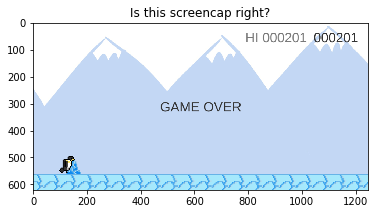

listener stopped!
playing game!
Listener 3 started!
Listener 3 stopped!


In [67]:
# bound coordinates for the screenshots
x1, y1, x2, y2 = 0, 0, 0, 0
arr = list()
inputs = list()
frameRate = 0

# Collect events until released
listener = keyboard.Listener(on_press = on_press, on_release = on_release)
listener.start()
print("Listener started!")

In [41]:
os.chdir(os.getcwd() + "/training_data")
currentTime = time.gmtime(time.time())
fileName = str(currentTime.tm_year) + str(currentTime.tm_mon)+ str(currentTime.tm_mday) + "_" + str(currentTime.tm_hour) + str(currentTime.tm_min) + str(currentTime.tm_sec)

# save inputs to text file
np.savetxt(fileName + "_" + "inputs" + ".txt", inputs, fmt = "%1.1u", header = "Key Presses")

# save numpy array of screencaps
np_arr = np.asarray(arr)
os.mkdir(fileName + "_" + "screencaps")
os.chdir(os.getcwd() + "/" + fileName + "_" + "screencaps")
for i in range(np_arr.shape[0]):
    np.savetxt("frame" + "_"  + str(i) + ".txt", np_arr[i], header = "Shape: " + str(np_arr[i].shape))
os.chdir("..")

# create and save animation
fig = plt.figure()
i = 0
frame = plt.imshow(np_arr[0], cmap = "gray", animated = True)
def update(*args):
    global i
    if (i < len(np_arr) - 1):
        i = i + 1
    else:
        i = 0
    frame.set_array(np_arr[i])
    return frame
anim = animation.FuncAnimation(fig, update, interval = frameRate, frames = len(np_arr) - 1)
anim.save(fileName + "_" + "video" + ".mp4")
plt.close()

os.chdir("..")

# create HTML preview file
HTML(anim.to_html5_video())

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 432x288 with 0 Axes>

In [44]:
# load old data
dataToUse = "201959_18345_"

os.chdir(os.getcwd() + "/training_data")
inputs = np.loadtxt(dataToUse + "inputs.txt")

os.chdir(os.getcwd() + "/" + dataToUse + "screencaps")
rawFrameData = list()

for i in range(len(glob.glob("*.txt"))):
    rawFrameData.append(np.loadtxt("frame_" + str(i) + ".txt"))
np_arr = np.asarray(rawFrameData)

os.chdir(os.getcwd() + "/../..")

In [45]:
# check image size
np_arr[0].shape

(31, 62)

In [10]:
model = Sequential()

In [11]:
model.add(GRU(units = 150, input_shape = (31, 62, ), return_sequences = True))

In [12]:
model.add(GRU(units = 75, return_sequences = False))

In [13]:
model.add(Dense(units = 1, activation = "sigmoid"))

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 31, 150)           95850     
_________________________________________________________________
gru_2 (GRU)                  (None, 75)                50850     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 76        
Total params: 146,776
Trainable params: 146,776
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer = "RMSprop", loss = "mean_squared_error", metrics = ["accuracy"])

In [46]:
model.fit(x = np_arr, y = inputs, batch_size = 32, epochs = 10, verbose = 2, validation_split = 0.1)

Train on 1345 samples, validate on 150 samples
Epoch 1/10
 - 7s - loss: 0.0509 - acc: 0.9472 - val_loss: 0.0686 - val_acc: 0.9267
Epoch 2/10
 - 4s - loss: 0.0501 - acc: 0.9472 - val_loss: 0.0696 - val_acc: 0.9267
Epoch 3/10
 - 4s - loss: 0.0511 - acc: 0.9472 - val_loss: 0.0692 - val_acc: 0.9267
Epoch 4/10
 - 4s - loss: 0.0499 - acc: 0.9472 - val_loss: 0.0689 - val_acc: 0.9267
Epoch 5/10
 - 5s - loss: 0.0495 - acc: 0.9472 - val_loss: 0.0664 - val_acc: 0.9267
Epoch 6/10
 - 4s - loss: 0.0517 - acc: 0.9457 - val_loss: 0.0680 - val_acc: 0.9267
Epoch 7/10
 - 4s - loss: 0.0480 - acc: 0.9472 - val_loss: 0.0658 - val_acc: 0.9267
Epoch 8/10
 - 4s - loss: 0.0567 - acc: 0.9264 - val_loss: 0.0575 - val_acc: 0.9267
Epoch 9/10
 - 4s - loss: 0.0431 - acc: 0.9450 - val_loss: 0.0562 - val_acc: 0.9267
Epoch 10/10
 - 4s - loss: 0.0425 - acc: 0.9472 - val_loss: 0.0559 - val_acc: 0.9267


In [7]:
from keras.models import load_model

In [56]:
model.save('model-it-works.h5')

In [68]:
model.predict(np.expand_dims(np_arr[100], axis = 0))

array([[0.02249125]], dtype=float32)

In [8]:
os.getcwd()

'C:\\Users\\Jason Jewik\\Documents\\GitHub\\PenguinRunAI'

In [24]:
model = load_model('model-201959_174219.h5')

In [38]:
model

In [42]:
os.getcwd()

'C:\\Users\\Jason Jewik\\Documents\\GitHub\\PenguinRunAI\\training_data'

In [43]:
os.chdir("..")

In [57]:
json = model.to_json()

In [58]:
json

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "GRU", "config": {"name": "gru_1", "trainable": true, "batch_input_shape": [null, 31, 62], "dtype": "float32", "return_sequences": true, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "units": 150, "activation": "tanh", "recurrent_activation": "hard_sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "recurrent_initializer": {"class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "recurrent_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "recurrent_constraint": null, "bias_constraint": null, "dropout": 0.0, "recurrent_dropout": 0.0, "implementation": 1, "reset_after": false}}, {"class_name": "

In [59]:
model.save_weights('weights.h5')

In [60]:
import h5py

In [61]:
model.save('model-it-works.h5')

In [62]:
del model

In [65]:
model = load_model('model-it-works.h5')

In [66]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 31, 150)           95850     
_________________________________________________________________
gru_2 (GRU)                  (None, 75)                50850     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 76        
Total params: 146,776
Trainable params: 146,776
Non-trainable params: 0
_________________________________________________________________
